**DRIVE MOUNTING**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**IMPORTING LIBRARIES**

In [0]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from random import shuffle
from keras.applications import MobileNet
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense, Activation, Dropout
import sys
import h5py

print ("Done!")

Done!


**HELPER FUNCTION**


The function print_progress is used to print the amount of videos processed

In [0]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print.
    sys.stdout.write(msg)
    sys.stdout.flush()

print ("Done!")

Done!


**DATA LOADING-**
The directory to place the video dataset

In [0]:
in_dir = "data"
in_dir = '/content/drive/My Drive/Colab Notebooks/VIOLENCE_DATASET_2'
print(in_dir)
print ("Done!")

Done!
/content/drive/My Drive/Colab Notebooks/VIOLENCE_DATASET_2


**DATA AUGMENTATION**




In [0]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".mp4"

print ("Done!")

Done!



**HELPER FUNCTION FOR ABSTRACTING VIDEO FRAMES**


Function to get 20 frames from a video file and convert the frame to a suitable format for the MobileNet Model.

In [0]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

print ("Done!")

Done!


**HELPER FUNCTION FOR DATA ANNOTATION**

In [0]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not violence
    labels = []   
   
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:1] == 'V':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'NV':
                labels.append([0,1])
                names.append(file_name)
                     
    #Dictionary       
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

print ("Done!")

Done!


In [0]:
#DATA ANNOTATION
names, labels = label_video_names(in_dir)

print ("Done!")

Done!


In [0]:
print(labels)
print(names)
print(len(names))

**PRE-TRAINED MODEL: MobileNet**

In [0]:
image_model = MobileNet(include_top=True, weights='imagenet')

**MODEL SUMMARY**

In [0]:
image_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [0]:
input_shape = image_model.layers[0].output_shape[1:3]
input_shape

(224, 224)

**MobileNet MODEL FLOWCHART**

The flow chart explains how the data flows when using the ImageNet model for Transfer Learning. We input and process 20 labeled video frames sequence in batch with the MobileNet model. Instead of selecting the final layer, just prior to the final classification layer of the model is selected. The so-called Transfer Values are saved to a cache file.With the resulting transfer-values saved to a cache file and all the videos been processed through the model, now the transfer-values are used as the input to LSTM neural network. The LSTM network is trained using the classes from the datasets (Violence, No-Violence).

In [0]:
# We will use the output of the layer prior to the final classification-layer
transfer_layer = image_model.get_layer('reshape_2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the MobileNet net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of MobileNet net have dimensions: ", transfer_values_size)

The input of the MobileNet net have dimensions: (224, 224)
The output of the selecter layer of MobileNet net have dimensions:  1000


**FUNCTION TO GET TRANSFER VALUES**

In [0]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

**GENERATOR THAT PROCESS ONE VIDEO THROUGH MobileNet**

In [0]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([20,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

**FUNCTION TO SAVE TRANSFER VALUES**

In [0]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

             # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [0]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

**DATASET SPLITING**

In [0]:
training_set = int(len(names)*0.9)
test_set = int(len(names)*0.1)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

**SAVING THE TRANSFER VALUES IN DISK BY PROCESSING ALL VIDEO FRAMES THROUGH MOBILENET**

In [0]:
make_files(training_set)

- Progress: 99.9%

In [0]:
make_files_test(test_set)

- Progress: 99.5%

**LOADING THE CACHED TRANSFER VALUES INTO MEMORY**

We have to load those transfer values into memory in order to train the LSTM net.Training the LSTM in different ways in order to see which way gets the best accuracy, if you didn't save the transfer values into disk you would have to process the whole videos each training. It's very time consuming processing.

In [0]:

def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [0]:

def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [0]:
data, target = process_alldata_training()


In [0]:
data_test, target_test = process_alldata_test()

**LSTM ARCHITECTURE**

In LSTM architecture we take into account the dimensions of the transfer values.

In [0]:
from keras.optimizers import adam,SGD,RMSprop
chunk_size = 1000
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
print(model.summary())

model.compile(loss='mean_squared_error', optimizer='adam' ,metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 512)               3098624   
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
_________________________________________________________________
activation_10 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                51250     
_________________________________________________________________
activation_11 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 102       
_________________________________________________________________
activation_12 (Activation)   (None, 2)                

In [0]:
epoch = 100
batchS = 500

history = model.fit(np.array(data[0:1750]), np.array(target[0:1750]), epochs=epoch,
                    validation_data=(np.array(data[1750:]), np.array(target[1750:])), 
                    batch_size=batchS, verbose=2)

Train on 1750 samples, validate on 55 samples
Epoch 1/100
 - 1s - loss: 0.2304 - accuracy: 0.6349 - val_loss: 0.1111 - val_accuracy: 0.8545
Epoch 2/100
 - 0s - loss: 0.0985 - accuracy: 0.8674 - val_loss: 0.0361 - val_accuracy: 0.9818
Epoch 3/100
 - 0s - loss: 0.0525 - accuracy: 0.9314 - val_loss: 0.0434 - val_accuracy: 0.9455
Epoch 4/100
 - 0s - loss: 0.0316 - accuracy: 0.9651 - val_loss: 0.0235 - val_accuracy: 0.9818
Epoch 5/100
 - 0s - loss: 0.0196 - accuracy: 0.9794 - val_loss: 0.0231 - val_accuracy: 0.9818
Epoch 6/100
 - 0s - loss: 0.0132 - accuracy: 0.9886 - val_loss: 0.0264 - val_accuracy: 0.9636
Epoch 7/100
 - 0s - loss: 0.0095 - accuracy: 0.9914 - val_loss: 0.0224 - val_accuracy: 0.9818
Epoch 8/100
 - 0s - loss: 0.0074 - accuracy: 0.9931 - val_loss: 0.0190 - val_accuracy: 0.9818
Epoch 9/100
 - 0s - loss: 0.0055 - accuracy: 0.9943 - val_loss: 0.0193 - val_accuracy: 0.9818
Epoch 10/100
 - 0s - loss: 0.0047 - accuracy: 0.9949 - val_loss: 0.0223 - val_accuracy: 0.9818
Epoch 11/100


**MODEL TESTING**

In [0]:
result = model.evaluate(np.array(data_test), np.array(target_test))

200/200 [==============================] - 0s 178us/step



**Print the model accuracy**

In [0]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.04514995038509369
accuracy 0.949999988079071


PLOTING ACCURACY VS EPOCH AND LOSS VS EPOCH

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


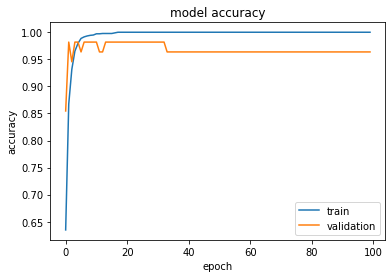

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


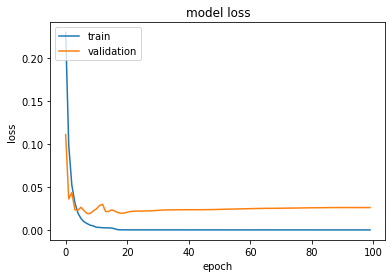

In [0]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

**VIDEO MACHINE**

The video machine is an interface between a Deep Learning Model and User. The system will take the input from the user and process it through the system. The system will hightlight the border with red color if violence is present otherwise green border will be added.

In [0]:
in_dir_1 = '/content/drive/My Drive/Colab Notebooks/VIOLENCE_DATASET_TEST'
print ("Done!")
print(in_dir_1)

#1,3,5,7-VIOLENCE VIDEO
#2,4,6,8-NON_VIOLENCE VIDEOS

Done!
/content/drive/My Drive/Colab Notebooks/VIOLENCE_DATASET_TEST


In [0]:
def video_names(in_dir_1):
    
    # list containing video names
    names1 = []

    for current_dir, dir_names,file_names in os.walk(in_dir_1):
        
        for file_name1 in file_names:
          
           names1.append(file_name1)

           #shuffle(names1)
                  
    return tuple(names1)

print ("Done!")

Done!


In [0]:
# Storing in names1
names1 = video_names(in_dir_1)
print ("Done!")

print(names1)

Done!
('V_4.mp4', 'V_2.mp4', 'V_6.mp4', 'V_1.mp4', 'V_3.mp4', 'V_5.mp4', 'V_7.avi', 'V_8.mp4')


In [0]:
video_no=names1[5]
print(video_no)

V_5.mp4


In [0]:
frames1 = get_frames(in_dir_1, video_no)
visible_frame = (frames1*255).astype('uint8')
#plt.imshow(visible_frame[10])
img_input=visible_frame[10]

In [0]:
from PIL import Image, ImageOps
from numpy import asarray

def add_border(input_image, output_image, border, color=0):
    img = Image.open(input_image)
    if isinstance(border, int) or isinstance(border, tuple):
        bimg = ImageOps.expand(img, border=border, fill=color)
    else:
        raise RuntimeError('Border is not an integer or tuple!')
    bimg.save(output_image)

In [0]:
gr_im= Image.fromarray(img_input).save('violence_1.jpg')
in_img = 'violence_1.jpg'


RESULT-VIOLENCE PRESENT


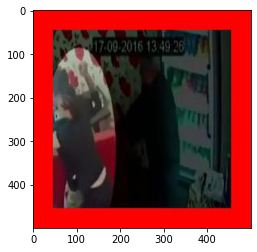

In [0]:
video = get_transfer_values(in_dir_1, video_no)
video = video.reshape((1, video.shape[0], video.shape[1]))
label = np.argmax(model.predict(video))

if(label==1):
  print('RESULT-VIOLENCE NOT PRESENT')
  color_br='green'
else:
  print('RESULT-VIOLENCE PRESENT')
  color_br='red'

add_border(in_img ,output_image='violence_final.jpg',border=25,color=color_br)
# load the image
image = np.array(Image.open('violence_final.jpg').resize((500,500)))
# convert image to numpy array
data = asarray(image)
plt.imshow(data)